In [5]:
from Samplers.sampler_test import *
from Samplers.plotting import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invwishart, dirichlet
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

data = pd.read_csv('data/NHANES_adults_data_preprocessed.csv')
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
cleaned_data = filtered_data[
    (filtered_data['bmi'] >= 10) & (filtered_data['bmi'] <= 80) &
    (filtered_data['sbp'] >= 70) & (filtered_data['sbp'] <= 270)
]
bmi_sbp_data = cleaned_data[['bmi', 'sbp']].sample(1000)

In [6]:
mean_bmi = bmi_sbp_data['bmi'].mean()
mean_sbp = bmi_sbp_data['sbp'].mean()
std_bmi = bmi_sbp_data['bmi'].std()
std_sbp = bmi_sbp_data['sbp'].std()
bmi_sbp_data.loc[:, 'bmi'] = (bmi_sbp_data['bmi'] - mean_bmi) / std_bmi
bmi_sbp_data.loc[:, 'sbp'] = (bmi_sbp_data['sbp'] - mean_sbp) / std_sbp
bmi_bounds = (np.array([18, 25, 30, np.inf])-mean_bmi)/std_bmi
sbp_bounds = (np.array([140, 160, np.inf])-mean_sbp)/std_sbp


In [7]:
from scipy.spatial.distance import pdist

def h1(mu):
    return np.min(pdist(mu))

def h2(mu):
    """
    Returns 1 if unique, 0 otherwise.
    """
    # Extract BMI and SBP values from mu
    bmi = mu[:, 0]
    sbp = mu[:, 1]
    
    # Use np.digitize to find interval indices for BMI and SBP
    bmi_blocks = np.digitize(bmi, bins=bmi_bounds)
    sbp_blocks = np.digitize(sbp, bins=sbp_bounds)
    
    # Combine BMI and SBP block indices into tuples
    blocks = set(zip(bmi_blocks, sbp_blocks))
    
    # If all blocks are unique, return 1; otherwise, return 0
    return 1 if len(blocks) == len(mu) else 0


Running Gibbs Sampler for sigma = 0.03


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:133: RuntimeWarning: divide by zero encountered in log
  + np.log(h(proposed_mu))
/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:137: RuntimeWarning: divide by zero encountered in log
  + np.log(h(mu))
/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:131: RuntimeWarning: invalid value encountered in scalar subtract
  log_acceptance_rate = (
Sampling: 100%|██████████| 1000/1000 [00:07<00:00, 132.85it/s]


Running Gibbs Sampler for sigma = 0.05


Sampling: 100%|██████████| 1000/1000 [00:07<00:00, 132.36it/s]


Running Gibbs Sampler for sigma = 0.08


Sampling: 100%|██████████| 1000/1000 [00:07<00:00, 132.95it/s]


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 1000/1000 [00:07<00:00, 133.10it/s]


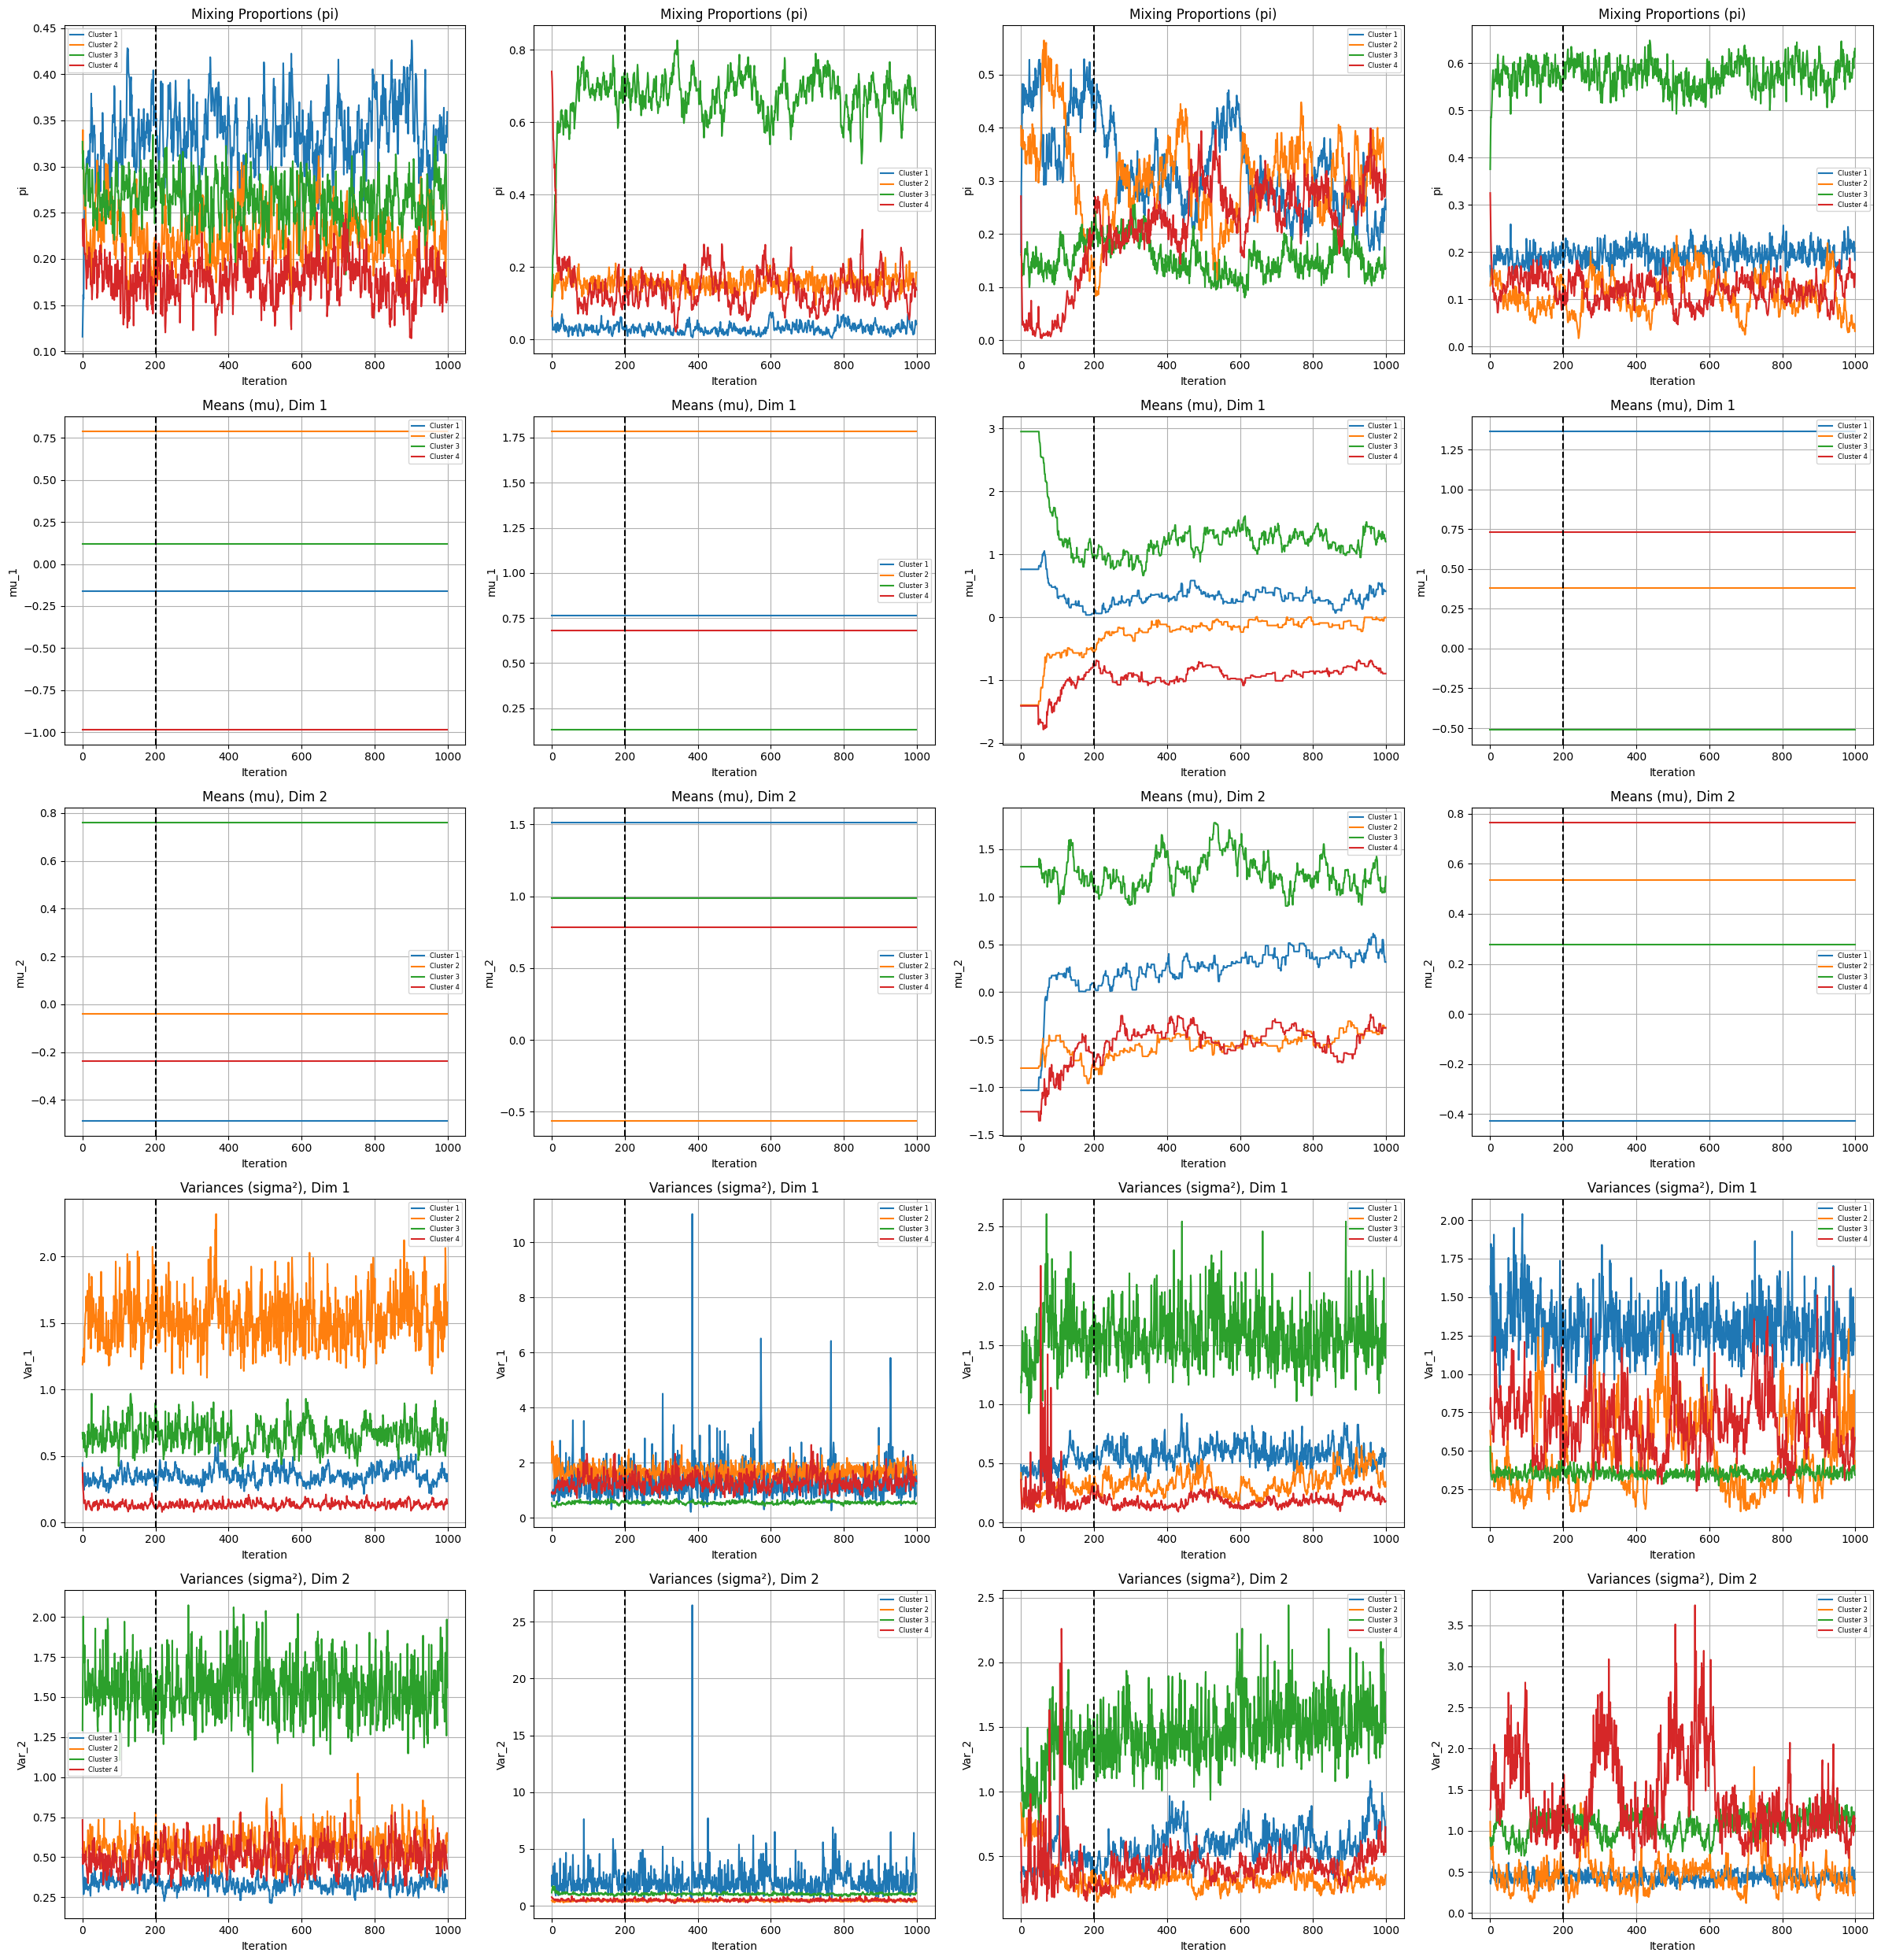

In [8]:
#set seed 42

# Parameters
# num_runs = 4
num_iterations = 1000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.03,0.05,0.08,0.1]
num_runs = len(sigma_vals)
all_run_samples = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = bayesian_repulsive_randomwalk(X, K, num_iterations, h2, 0, sig)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=200)
plt.tight_layout()
plt.show()




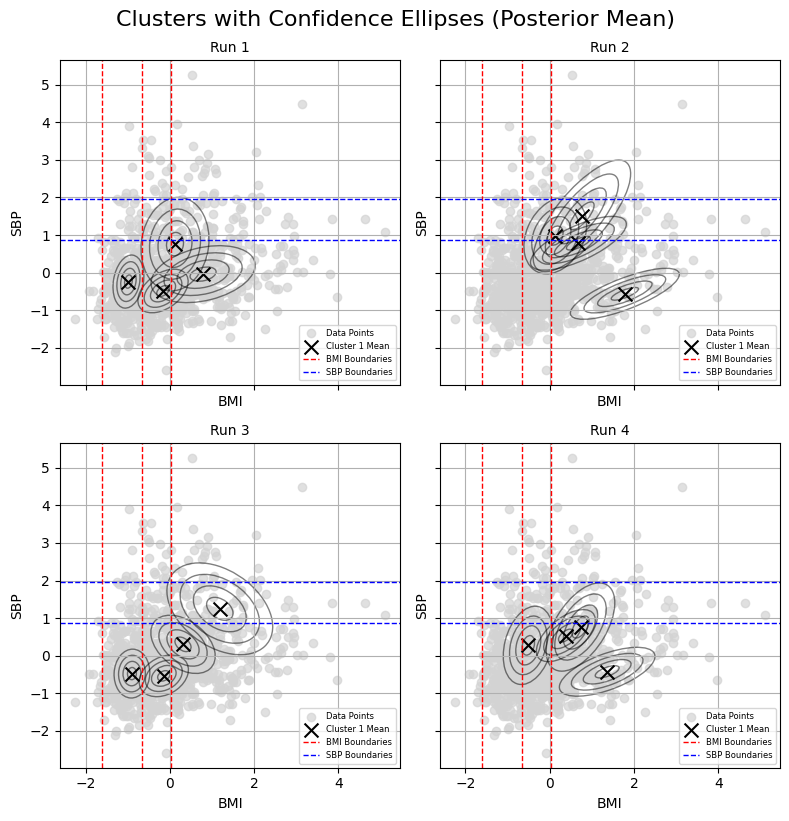

In [9]:
ellipse_mean(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in=200)

Sampling: 100%|██████████| 2000/2000 [00:13<00:00, 143.34it/s]


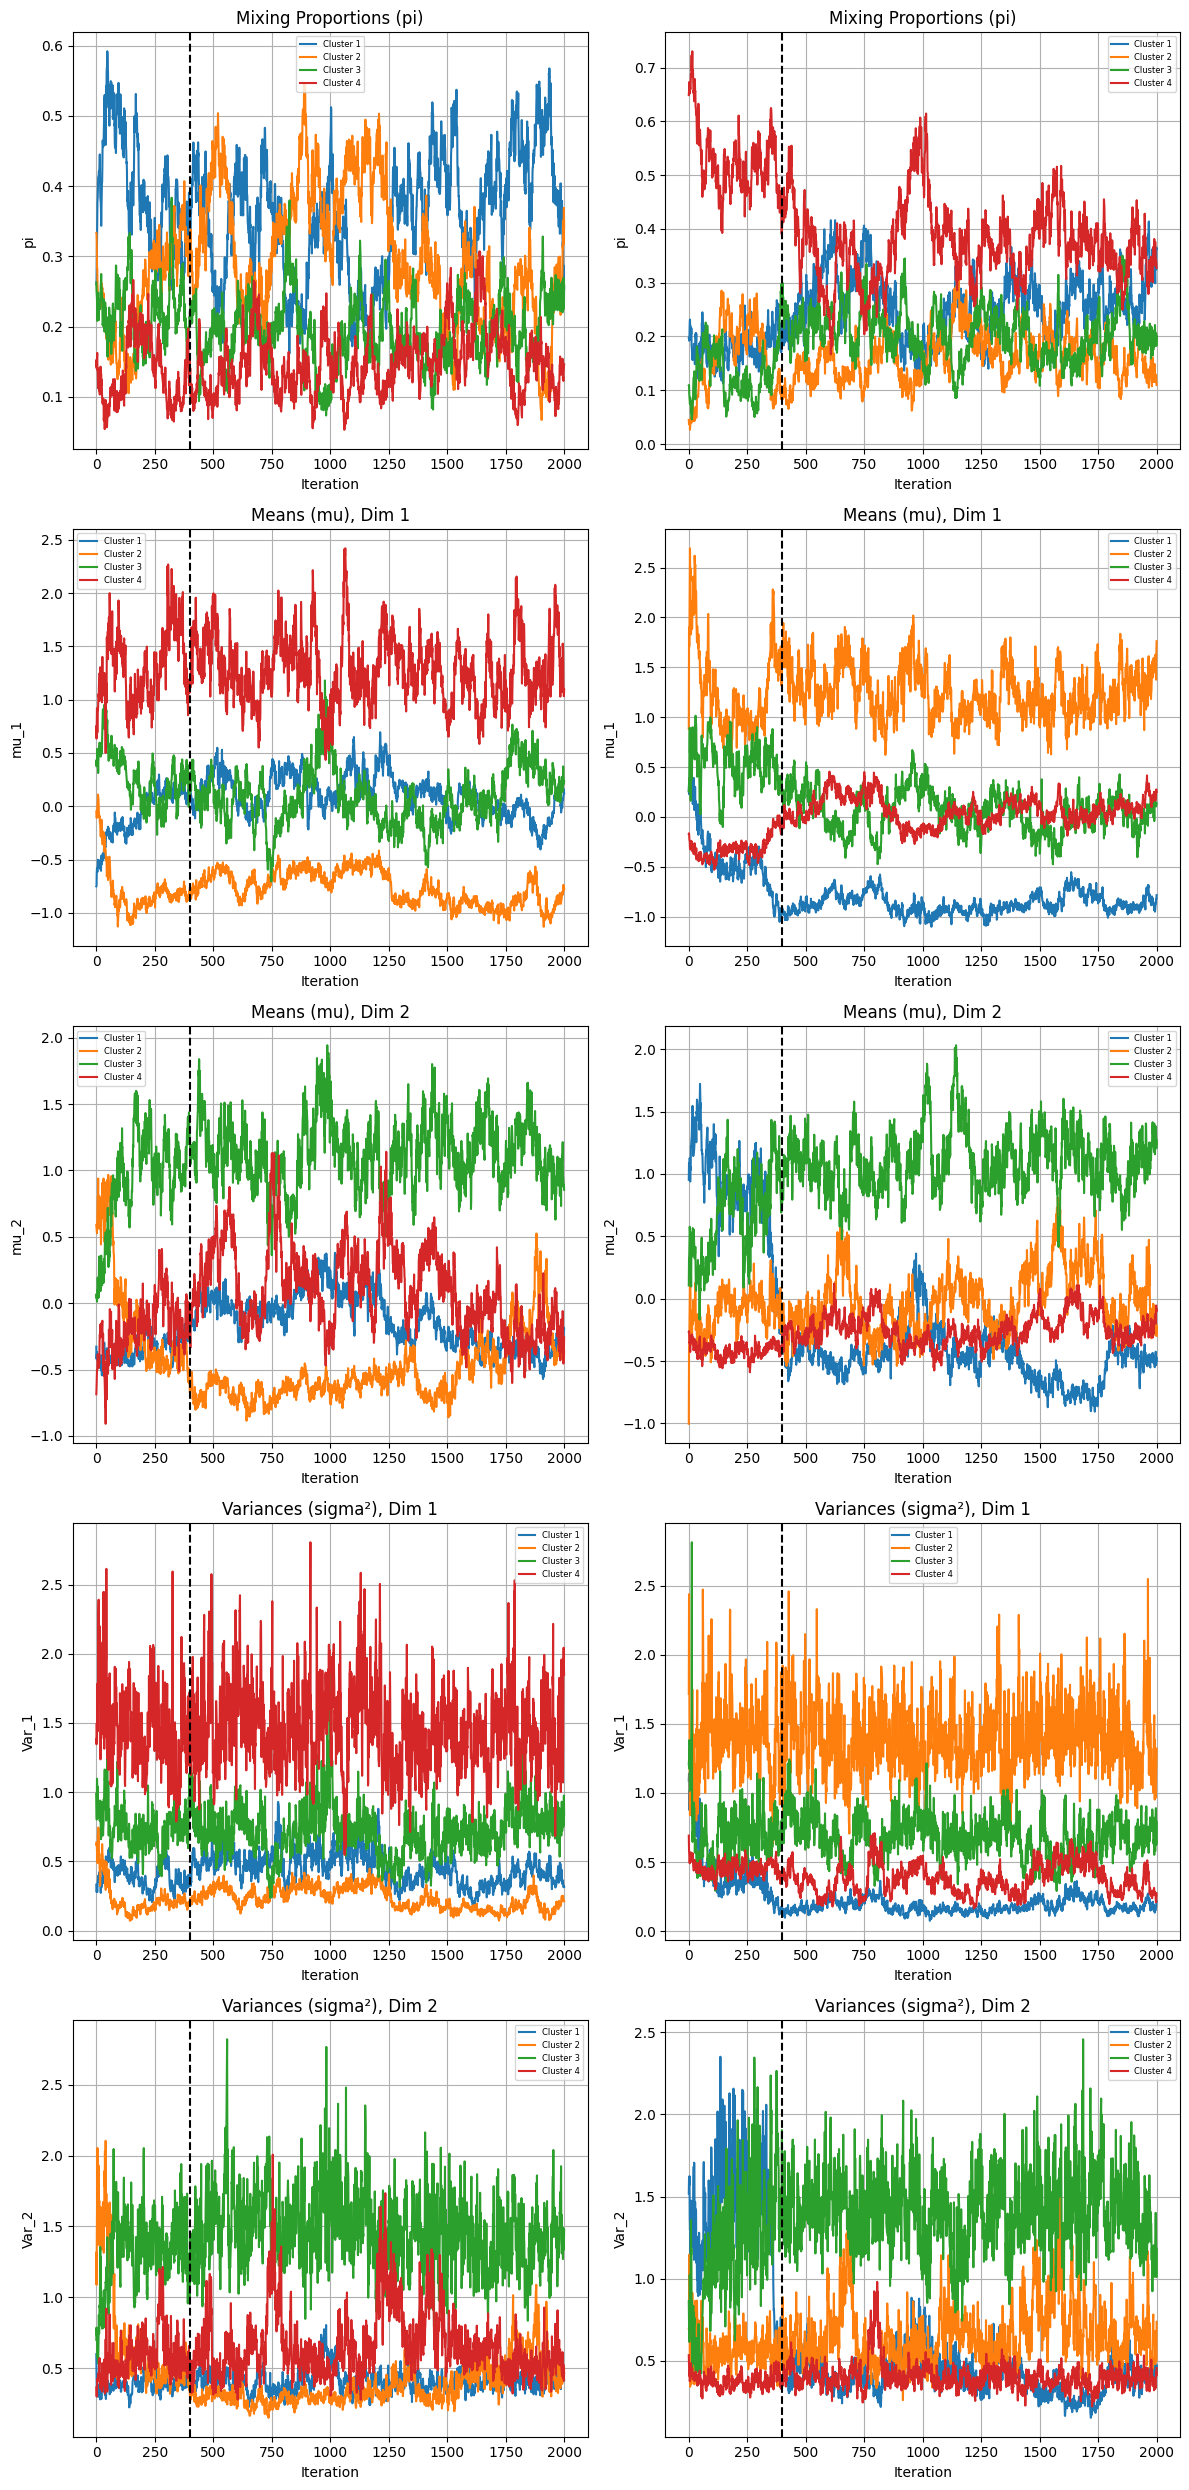

In [10]:
np.random.seed(42)
# Parameters
# num_runs = 2
num_iterations = 2000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
num_runs = 2
all_run_samples = []

for i in range(num_runs):
    run_samples = gibbs_sampler_gmm_multivariate(X, K, num_iterations, 0)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=400)
plt.tight_layout()
plt.show()




<Figure size 800x300 with 0 Axes>

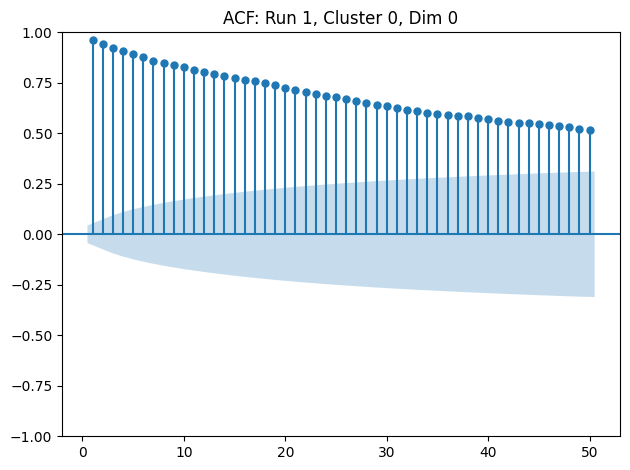

<Figure size 800x300 with 0 Axes>

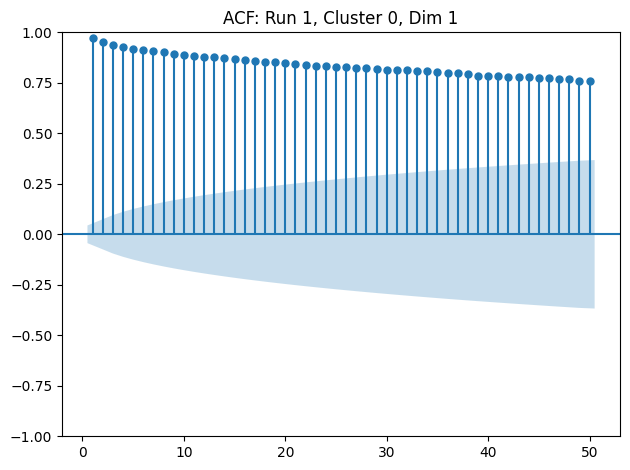

<Figure size 800x300 with 0 Axes>

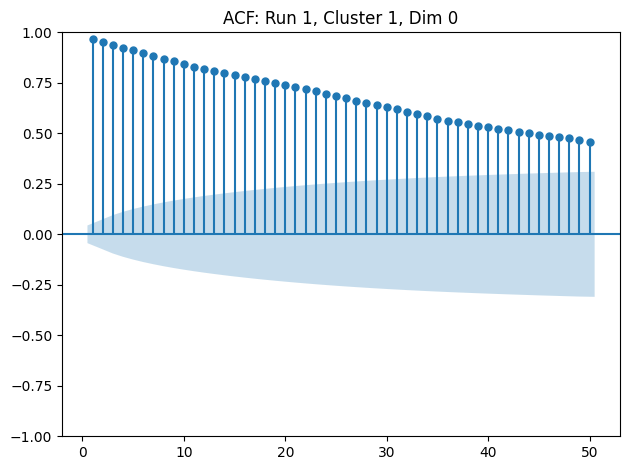

<Figure size 800x300 with 0 Axes>

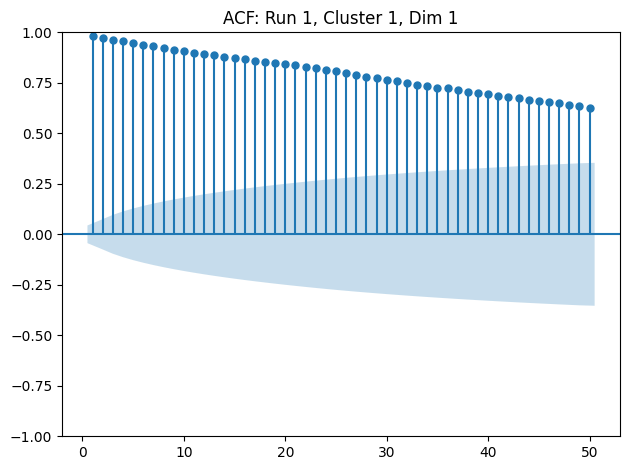

<Figure size 800x300 with 0 Axes>

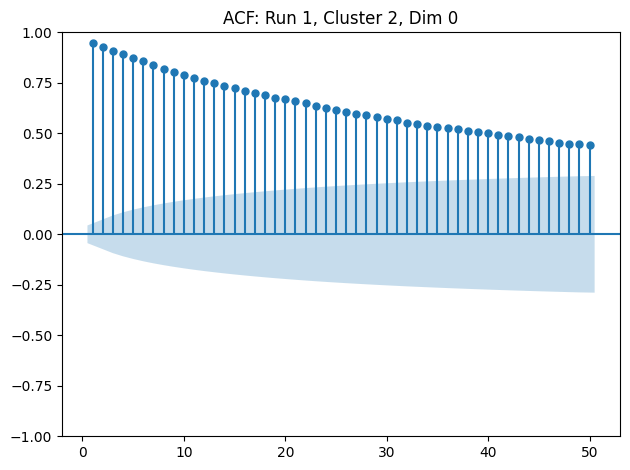

<Figure size 800x300 with 0 Axes>

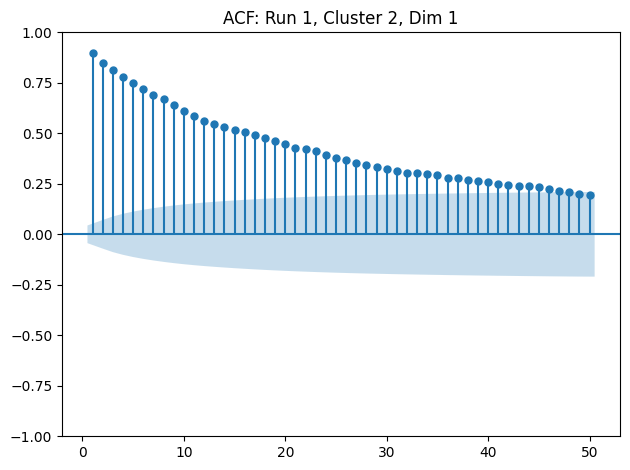

<Figure size 800x300 with 0 Axes>

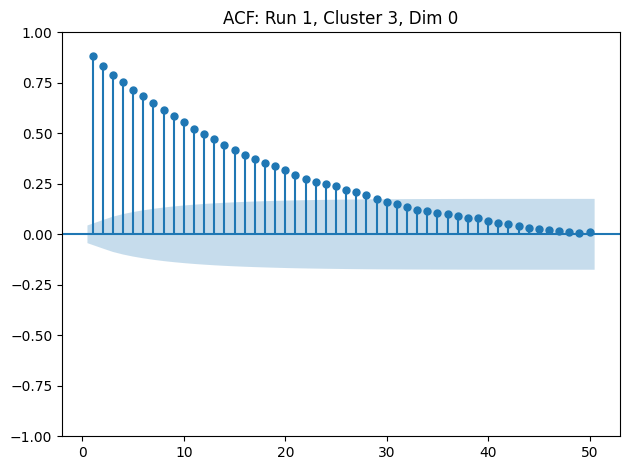

<Figure size 800x300 with 0 Axes>

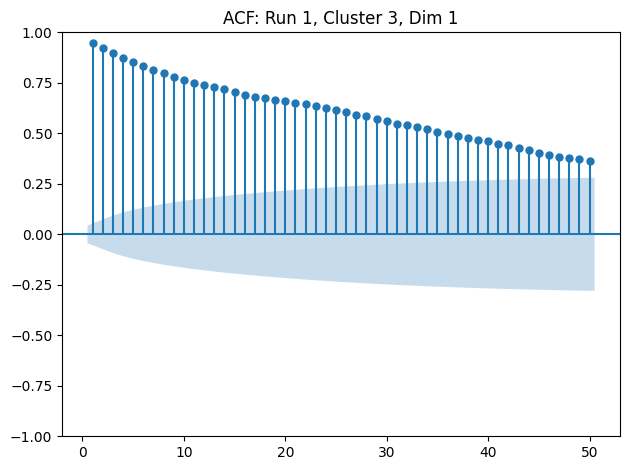

<Figure size 800x300 with 0 Axes>

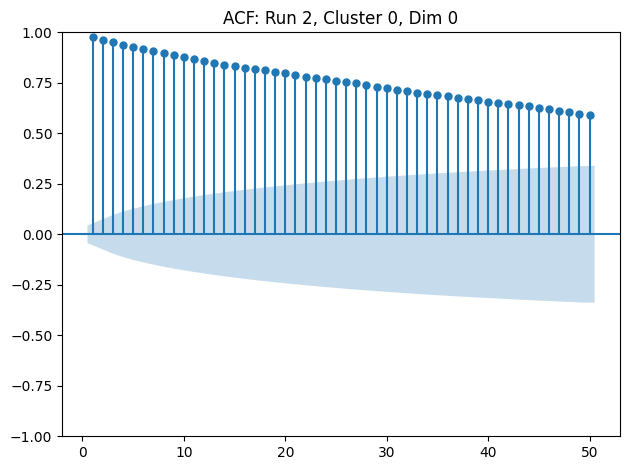

<Figure size 800x300 with 0 Axes>

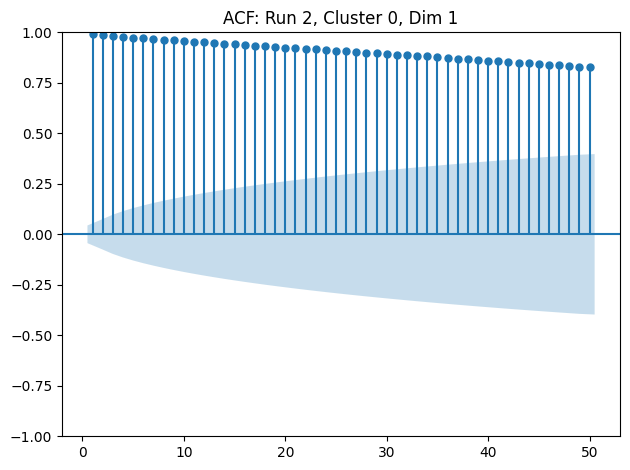

<Figure size 800x300 with 0 Axes>

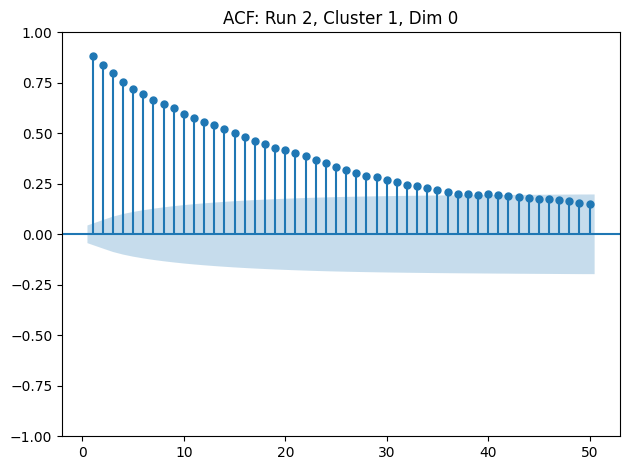

<Figure size 800x300 with 0 Axes>

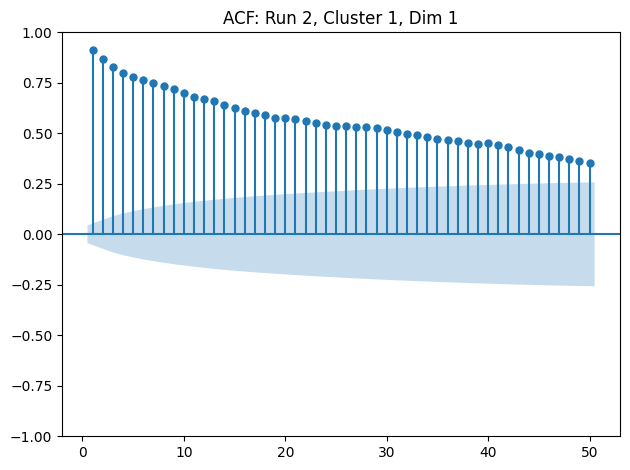

<Figure size 800x300 with 0 Axes>

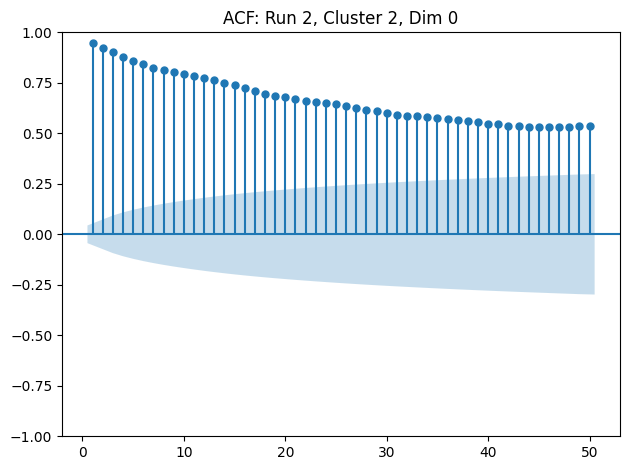

<Figure size 800x300 with 0 Axes>

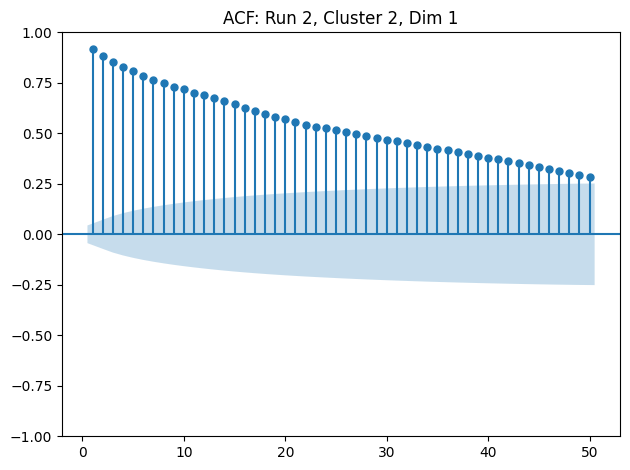

<Figure size 800x300 with 0 Axes>

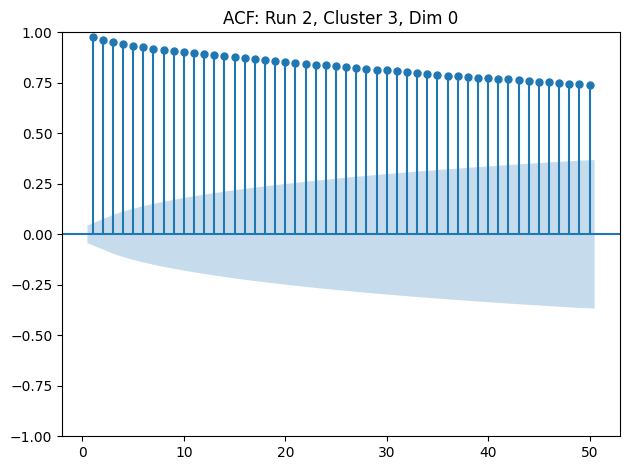

<Figure size 800x300 with 0 Axes>

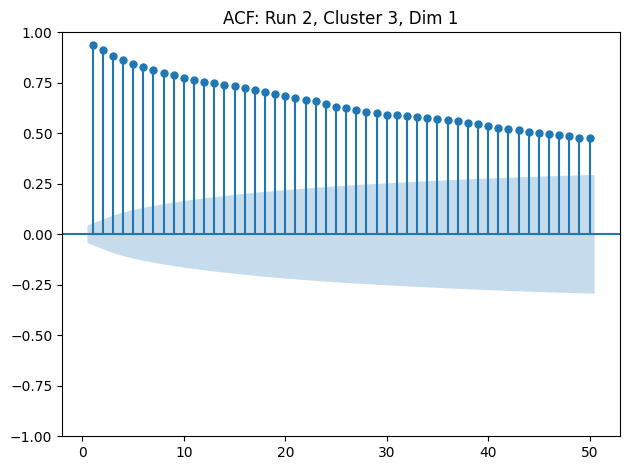

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Extract mu samples from each run: shape (num_iterations, K, p)
# For example, p = 2 (BMI and SBP)
for run_idx, run_samples in enumerate(all_run_samples):
    mu_samples = np.array([s[1] for s in run_samples])  # shape (T, K, p)
    T, K, p = mu_samples.shape
    
    for k in range(K):
        for dim in range(p):
            plt.figure(figsize=(8, 3))
            plot_acf(mu_samples[:, k, dim], lags=50, title=f'ACF: Run {run_idx+1}, Cluster {k}, Dim {dim}', zero=False)
            plt.tight_layout()
            plt.show()

Running Gibbs Sampler for sigma = 0.01


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 142.91it/s]


Running Gibbs Sampler for sigma = 0.05


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 143.83it/s]


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 143.69it/s]


Running Gibbs Sampler for sigma = 0.15


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 143.47it/s]


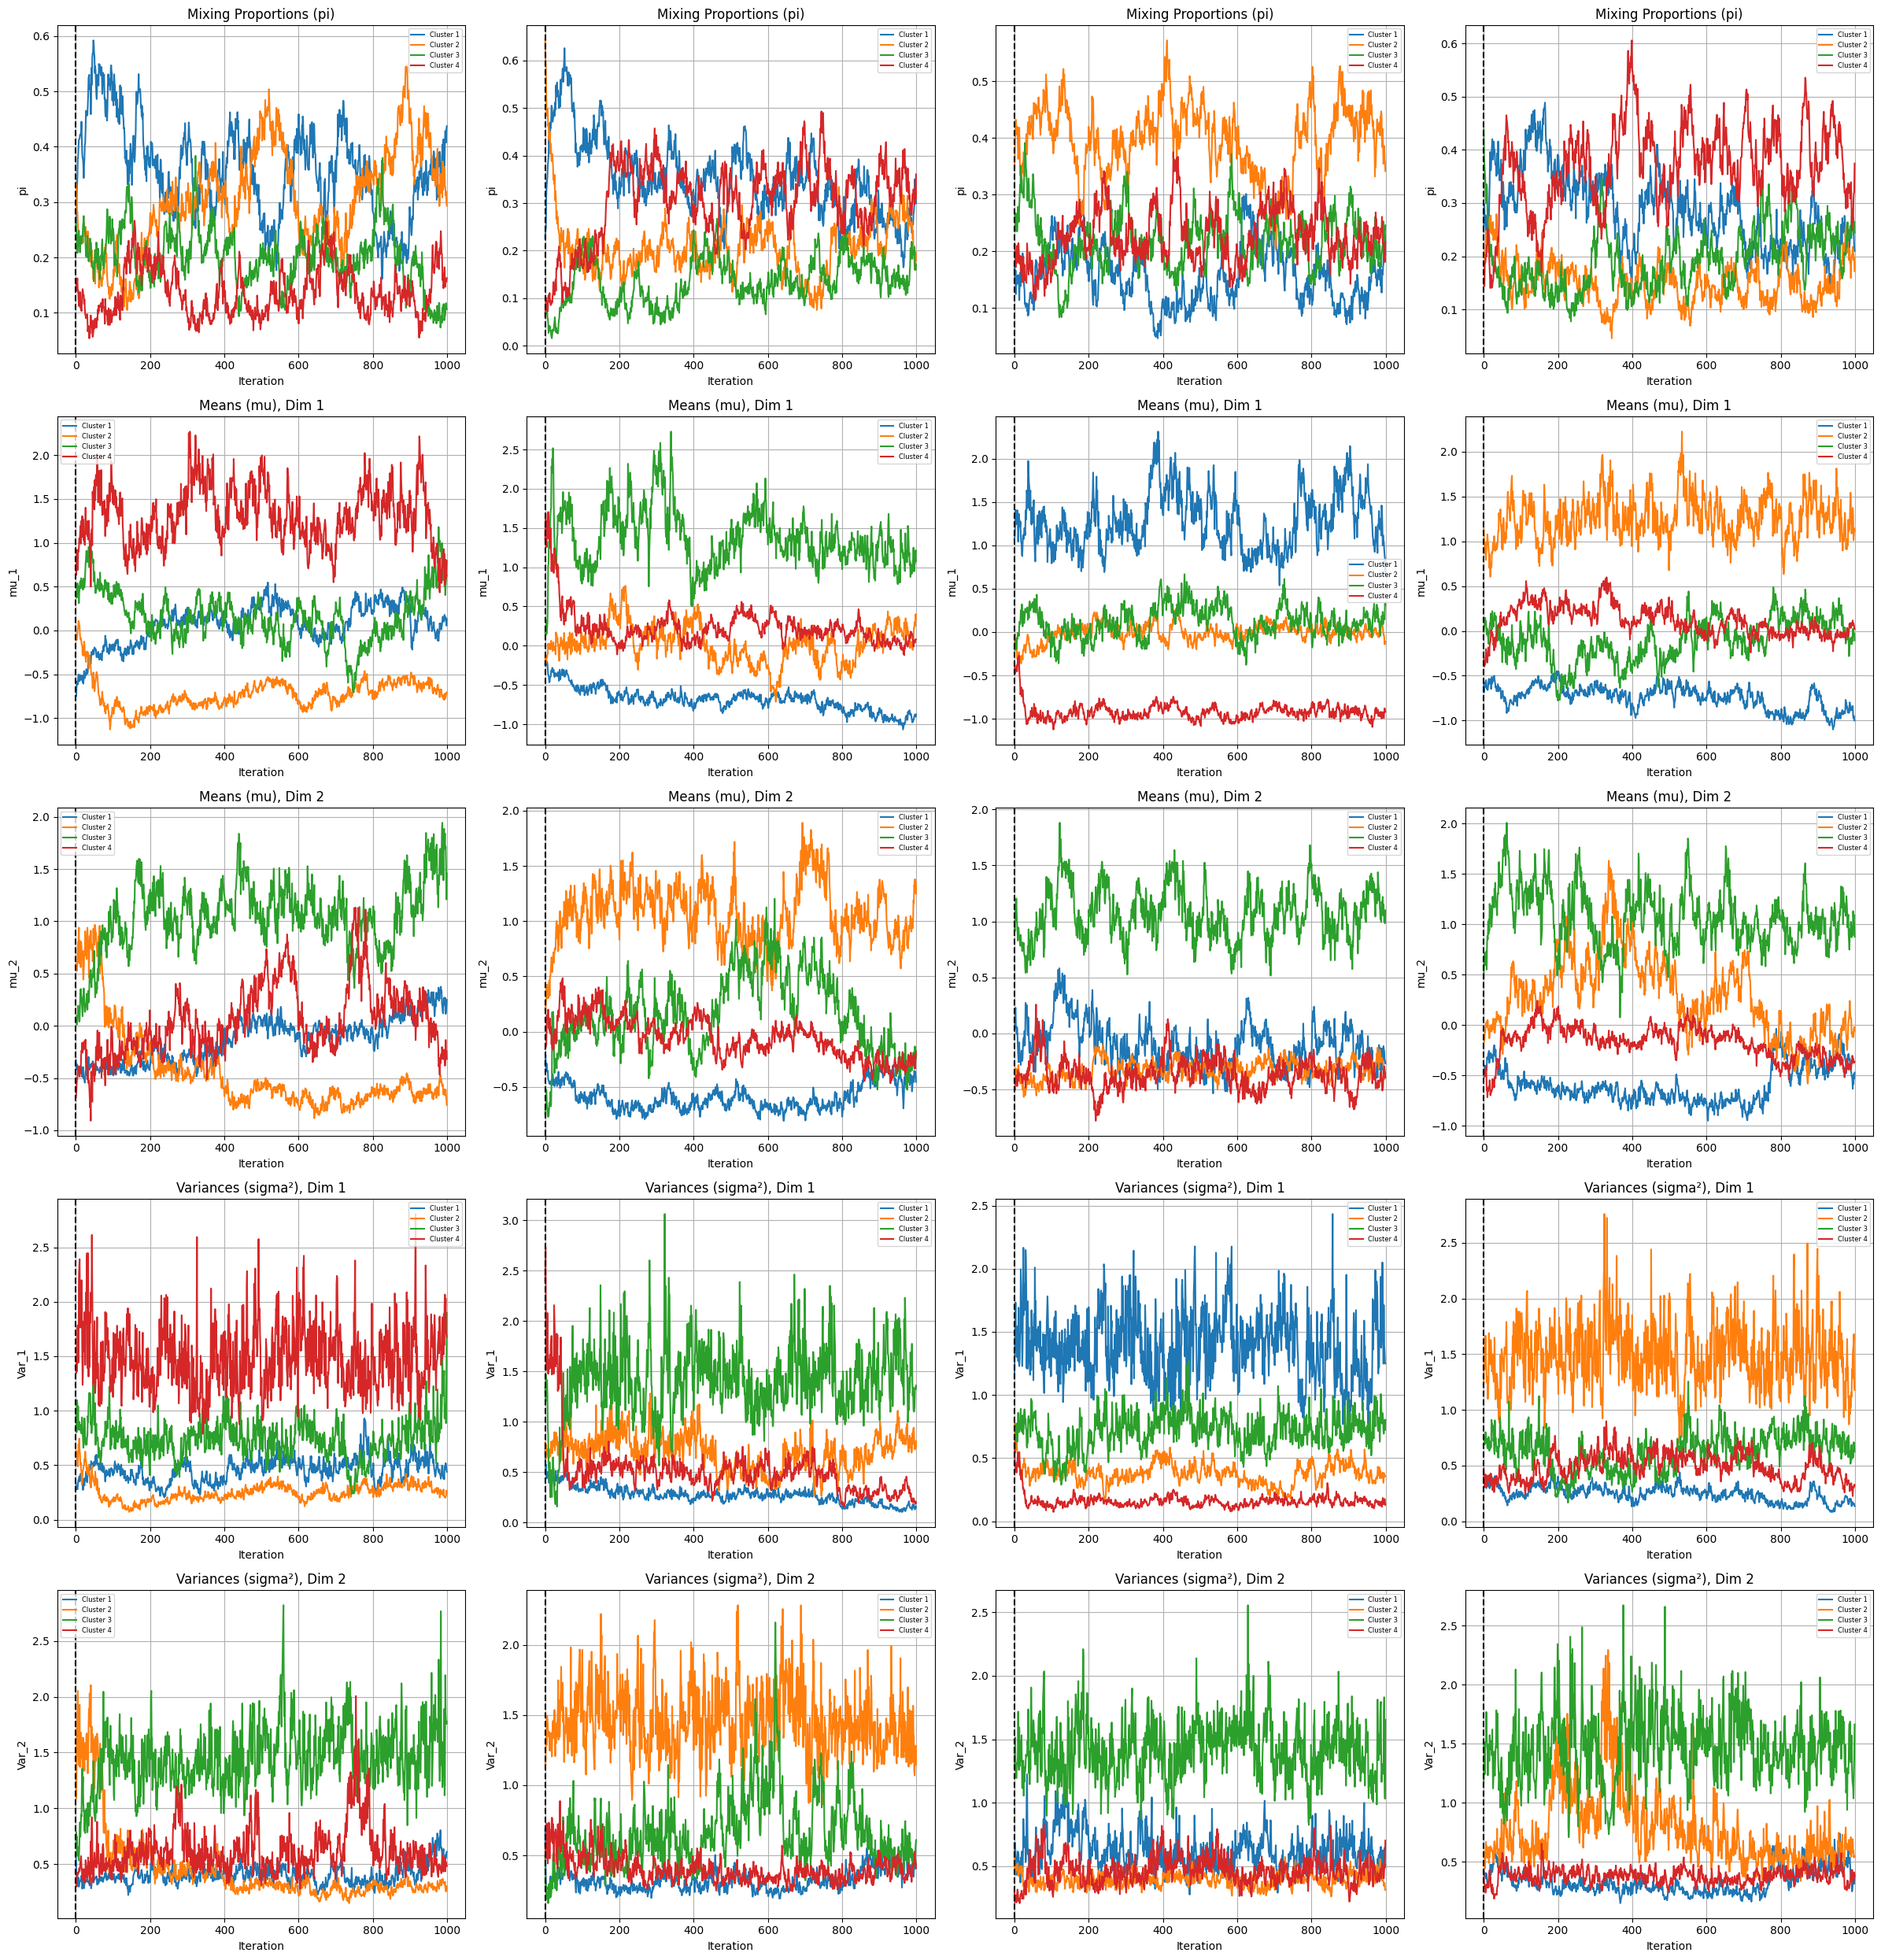

In [12]:
np.random.seed(42)
# Parameters
# num_runs = 4
num_iterations = 1000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.01, 0.05, 0.1, 0.15]
num_runs = len(sigma_vals)
all_run_samples = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = gibbs_sampler_gmm_multivariate(X, K, num_iterations, burn_in=0)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:133: RuntimeWarning: divide by zero encountered in log
  + np.log(h(proposed_mu))
/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:137: RuntimeWarning: divide by zero encountered in log
  + np.log(h(mu))
/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:131: RuntimeWarning: invalid value encountered in scalar subtract
  log_acceptance_rate = (
Sampling: 100%|██████████| 10000/10000 [01:17<00:00, 129.42it/s]


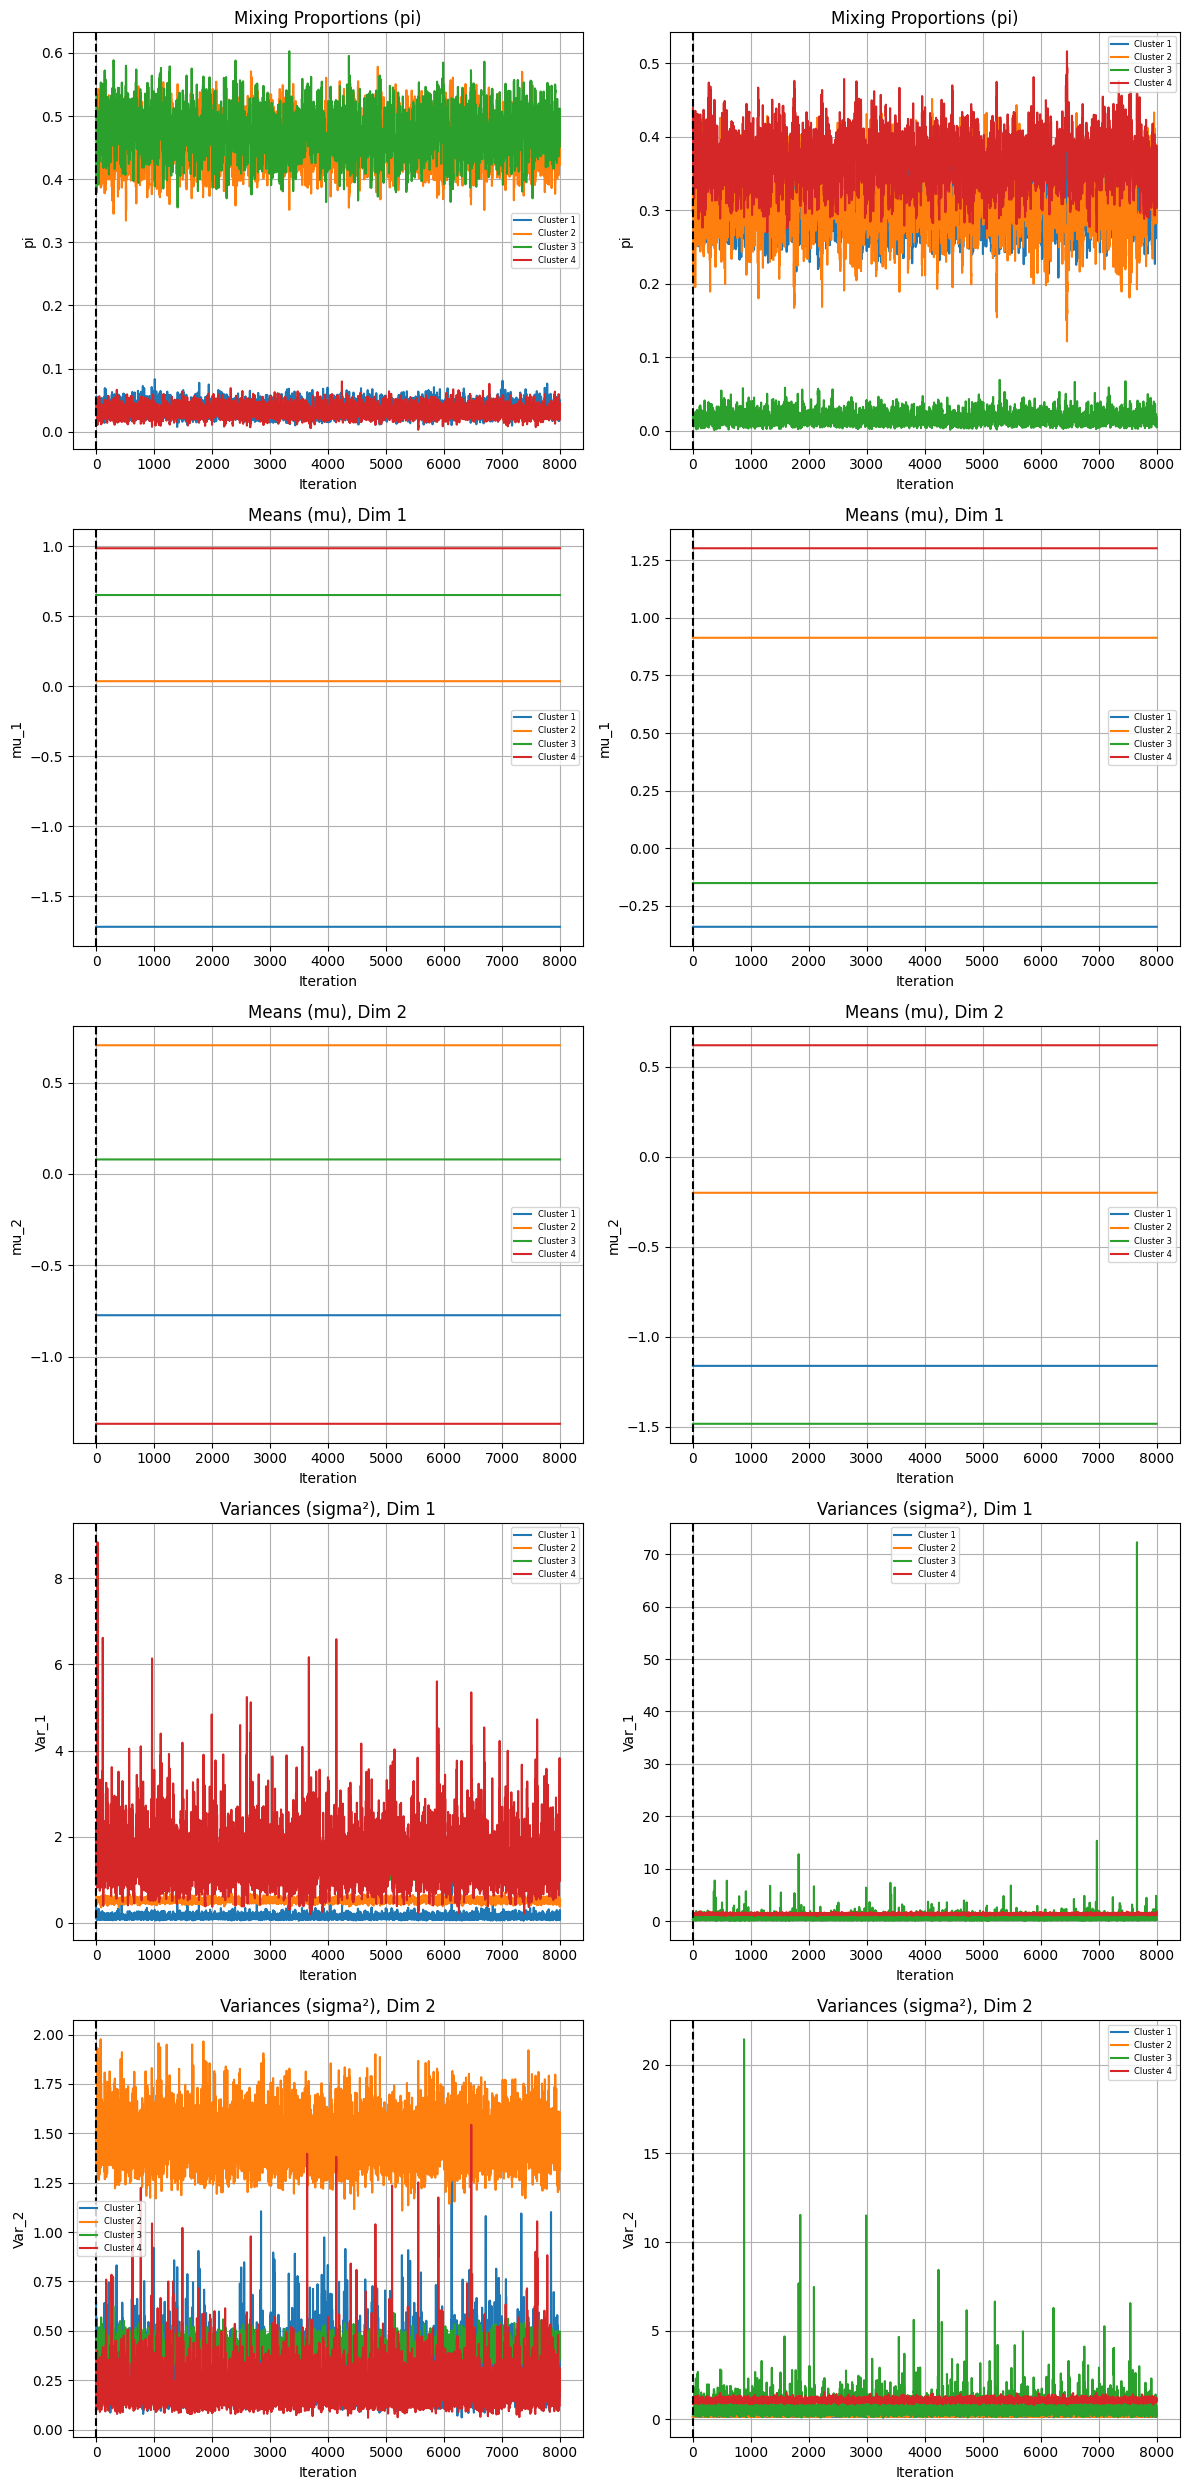

In [13]:
np.random.seed(42)
# Parameters
# num_runs = 2
num_iterations = 10000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
num_runs = 2
all_run_samples = []
sigma_vals =[0.05, 0.1]

for sigma in sigma_vals:
    run_samples = bayesian_repulsive_randomwalk(X, K, num_iterations, h2, 2000, sigma)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




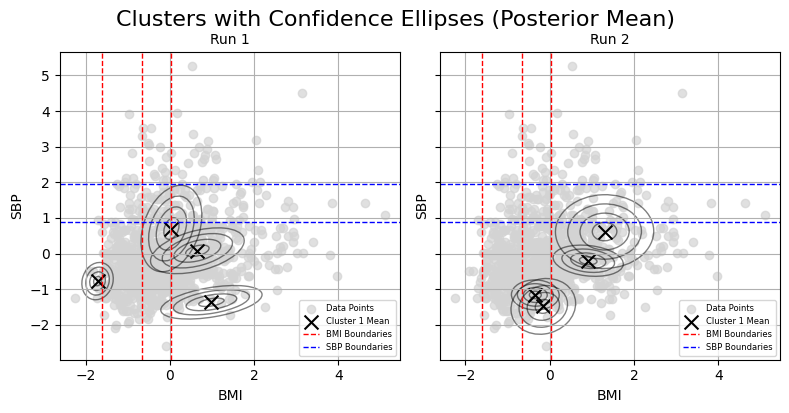

In [14]:
ellipse_mean(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in=100)

In [15]:

def compute_ess(chain):
    """
    Compute effective sample size (ESS) for a univariate MCMC chain.
    
    Parameters:
        chain : ndarray
            1D array of samples.
            
    Returns:
        ess : float
            Effective sample size.
    """
    N = len(chain)
    chain_centered = chain - np.mean(chain)
    acf = [1.0]
    for lag in range(1, N):
        c = np.corrcoef(chain_centered[:-lag], chain_centered[lag:])[0, 1]
        if c < 0:
            break
        acf.append(c)
    return N / (1 + 2 * np.sum(acf[1:]))

# Suppose you have run your sampler and collected samples as follows:
# all_run_samples is a list of runs, each being a list of samples (pi, mu, Sigma, z)
# Let's assume you have chosen one run and applied burn-in:
# (This would typically be done after running your sampler.)
burn_in = 0
# Convert lists of samples into arrays for easy slicing:
# For example, mu_samples will have shape (T, K, p)
mu_samples = np.array([s[1] for s in all_run_samples[0][burn_in:]])
pi_samples = np.array([s[0] for s in all_run_samples[0][burn_in:]])


# You can loop over clusters and dimensions to compute ESS for all parameters.
for k in range(pi_samples.shape[1]):
    ess_pi = compute_ess(pi_samples[:, k])
    print(f"ESS for mixing proportions, cluster {k}: {ess_pi:.2f}")

for k in range(mu_samples.shape[1]):
    for dim in range(mu_samples.shape[2]):
        ess_mu = compute_ess(mu_samples[:, k, dim])
        print(f"ESS for cluster {k}, dimension {dim}: {ess_mu:.2f}")

ESS for mixing proportions, cluster 0: 2602.39
ESS for mixing proportions, cluster 1: 916.88
ESS for mixing proportions, cluster 2: 859.16
ESS for mixing proportions, cluster 3: 1630.17


/Users/yunjiaqi/Desktop/M4R/myvenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yunjiaqi/Desktop/M4R/myvenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/yunjiaqi/Desktop/M4R/myvenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/yunjiaqi/Desktop/M4R/myvenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ESS for cluster 0, dimension 0: nan
ESS for cluster 0, dimension 1: nan
ESS for cluster 1, dimension 0: nan
ESS for cluster 1, dimension 1: nan
ESS for cluster 2, dimension 0: nan
ESS for cluster 2, dimension 1: nan
ESS for cluster 3, dimension 0: nan
ESS for cluster 3, dimension 1: nan


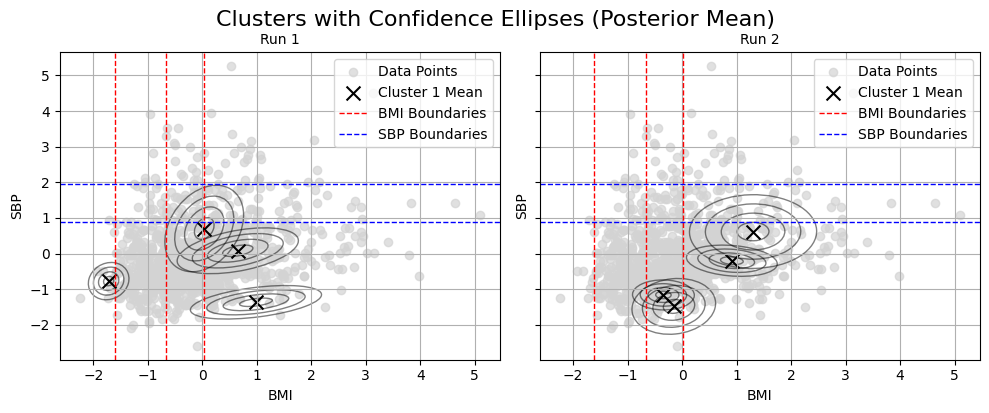

In [16]:
# Compute posterior estimates for each run using samples after burn-in
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    # Use samples after burn-in for this run:
    run_samples_burned = run_samples[burn_in:]
    # Extract cluster means and covariances from the post-burn-in samples:
    mu_samples = np.array([s[1] for s in run_samples_burned])       # shape: (T, K, p)
    sigma_samples = np.array([s[2] for s in run_samples_burned])    # shape: (T, K, p, p)
    
    # Compute the posterior (averaged) estimates:
    posterior_mu = np.mean(mu_samples, axis=0)       # shape: (K, p)
    posterior_sigma = np.mean(sigma_samples, axis=0) # shape: (K, p, p)
    
    # Our plotting function expects sample arrays; we can wrap these in a singleton dimension.
    plot_with_reference_lines(np.expand_dims(posterior_mu, axis=0),
                              np.expand_dims(posterior_sigma, axis=0),
                              X, bmi_bounds, sbp_bounds, ax=ax) 
    ax.set_title(f"Run {run + 1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Clusters with Confidence Ellipses (Posterior Mean)", fontsize=16, y=1.02)
plt.show()

In [17]:

burn_in = 1000
# Convert lists of samples into arrays for easy slicing:
# For example, mu_samples will have shape (T, K, p)
mu_samples = np.array([s[1] for s in all_run_samples[0][burn_in:]])
pi_samples = np.array([s[0] for s in all_run_samples[0][burn_in:]])


# You can loop over clusters and dimensions to compute ESS for all parameters.
for k in range(pi_samples.shape[1]):
    ess_pi = compute_ess(pi_samples[:, k])
    print(f"ESS for mixing proportions, cluster {k}: {ess_pi:.2f}")

for k in range(mu_samples.shape[1]):
    for dim in range(mu_samples.shape[2]):
        ess_mu = compute_ess(mu_samples[:, k, dim])
        print(f"ESS for cluster {k}, dimension {dim}: {ess_mu:.2f}")

ESS for mixing proportions, cluster 0: 2268.28
ESS for mixing proportions, cluster 1: 824.81
ESS for mixing proportions, cluster 2: 746.19
ESS for mixing proportions, cluster 3: 1180.63
ESS for cluster 0, dimension 0: nan
ESS for cluster 0, dimension 1: nan
ESS for cluster 1, dimension 0: nan
ESS for cluster 1, dimension 1: nan
ESS for cluster 2, dimension 0: nan
ESS for cluster 2, dimension 1: nan
ESS for cluster 3, dimension 0: nan
ESS for cluster 3, dimension 1: nan


In [ ]:
ellipse_lastit(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in)

KeyboardInterrupt: 

In [ ]:
# Compute posterior estimates for each run using samples after burn-in
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    # Use samples after burn-in for this run:
    run_samples_burned = run_samples[burn_in:]
    # Extract cluster means and covariances from the post-burn-in samples:
    mu_samples = np.array([s[1] for s in run_samples_burned])       # shape: (T, K, p)
    sigma_samples = np.array([s[2] for s in run_samples_burned])    # shape: (T, K, p, p)
    
    # Compute the posterior (averaged) estimates:
    posterior_mu = np.mean(mu_samples, axis=0)       # shape: (K, p)
    posterior_sigma = np.mean(sigma_samples, axis=0) # shape: (K, p, p)
    
    # Our plotting function expects sample arrays; we can wrap these in a singleton dimension.
    plot_with_reference_lines(np.expand_dims(posterior_mu, axis=0),
                              np.expand_dims(posterior_sigma, axis=0),
                              X, bmi_bounds, sbp_bounds, ax=ax) 
    ax.set_title(f"Run {run + 1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Clusters with Confidence Ellipses (Posterior Mean)", fontsize=16, y=1.02)
plt.show()

In [ ]:
# Compute posterior estimates using only samples after burn-in for one run
run_samples_burned = all_run_samples[0][burn_in:]
pi_samples = np.array([s[0] for s in run_samples_burned])
mu_samples = np.array([s[1] for s in run_samples_burned])
sigma_samples = np.array([s[2] for s in run_samples_burned])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




In [ ]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
def h1(mu):
    return np.min(pdist(mu))*2

In [ ]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




In [ ]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
def h1(mu):
    return np.min(pdist(mu))*3
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 3000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




In [ ]:
§
pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)
